In [11]:
import numpy as np
from transformers import RobertaTokenizer, RobertaModel
import torch
from tqdm import tqdm
print(torch.cuda.is_available())
device = 'cuda'

# Load CodeBERT model and tokenizer
tokenizer = RobertaTokenizer.from_pretrained("microsoft/codebert-base")
model = RobertaModel.from_pretrained("microsoft/codebert-base").to(device)


# Function to generate embeddings in batches
def get_embeddings_in_batches(commands, batch_size=16):
    embeddings = []
    for i in tqdm(range(0, len(commands), batch_size)):
        batch = commands[i:i + batch_size]
        
        # Tokenize batch of commands
        inputs = tokenizer(batch, return_tensors="pt", truncation=True, padding=True, max_length=128)
        
        # Move inputs to device
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        # Generate embeddings
        with torch.no_grad():
            outputs = model(**inputs)
            batch_embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()  # Move to CPU after computation
        
        embeddings.extend(batch_embeddings)
    
    return np.array(embeddings)

True


In [37]:
import numpy as np
import pandas as pd

# load data
with open('data/nl2bash.cm') as f:
    benign_data = pd.DataFrame({'command': f.readlines(), 'label' : 0})
print(f'{len(benign_data)=}')

with open('data/malicious.cm') as f:
    malicious_data = pd.DataFrame({'command': f.readlines(), 'label' : 1})
print(f'{len(malicious_data)=}')
data = pd.concat([benign_data, malicious_data], ignore_index=True)


# Generate embeddings
embeddings: np.ndarray = get_embeddings_in_batches(data['command'].tolist())


len(benign_data)=12607
len(malicious_data)=123


100%|██████████| 796/796 [00:19<00:00, 41.15it/s]


In [38]:
# examine tokenizer
for i in range(5):
    print(data.command[i])
    print(tokenizer([data.command[i]]))

top -b -d2 -s1 | sed -e '1,/USERNAME/d' | sed -e '1,/^$/d'

{'input_ids': [[0, 8766, 111, 428, 111, 417, 176, 111, 29, 134, 1721, 10195, 111, 242, 128, 134, 6, 73, 47955, 48307, 73, 417, 108, 1721, 10195, 111, 242, 128, 134, 6, 73, 35227, 1629, 73, 417, 108, 50118, 2]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}
top -b -n 1 -u abc | awk 'NR>7 { sum += $9; } END { print sum; }'

{'input_ids': [[0, 8766, 111, 428, 111, 282, 112, 111, 257, 4091, 438, 1721, 19267, 330, 128, 17085, 15698, 406, 25522, 6797, 49371, 68, 466, 131, 35524, 34588, 25522, 5780, 6797, 131, 35524, 108, 50118, 2]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}
top -b -d 5 -n 2 | awk '$1 == "PID" {block_num++; next} block_num == 2 {sum += $9;} END {print sum}'

{'input_ids': [[0, 8766, 111, 428, 111, 417, 195, 111, 282, 132, 1721, 19267, 330, 128, 162

In [45]:
# examine embeddings
embedding_norms = np.sqrt((embeddings * embeddings).sum(axis=1))
for i in range(5):
    print('Closest elements')
    print('command 1: ', data.command[i])
    command_embedding = embeddings[i]
    command_norm = np.sqrt((command_embedding * command_embedding).sum())
    cosines = np.matmul(embeddings, command_embedding.T)/(command_norm * embedding_norms)
    # Find the index of the largest element
    largest_idx = np.argmax(cosines)
    # Temporarily replace the largest element with a very small value
    cosines[largest_idx] = -np.inf

    # Find the index of the second largest element
    second_largest_idx = np.argmax(cosines)
    print('command 2: ', data.command[second_largest_idx])

Closest elements
command 1:  top -b -d2 -s1 | sed -e '1,/USERNAME/d' | sed -e '1,/^$/d'

command 2:  nl -n rz ca | awk -vOFS="\t" '/Ca/{$1="#"$2} {$1=$1}1' | sort -k1,1 | cut -f2-

Closest elements
command 1:  top -b -n 1 -u abc | awk 'NR>7 { sum += $9; } END { print sum; }'

command 2:  top -b -d 5 -n 2 | awk '$1 == "PID" {block_num++; next} block_num == 2 {sum += $9;} END {print sum}'

Closest elements
command 1:  top -b -d 5 -n 2 | awk '$1 == "PID" {block_num++; next} block_num == 2 {sum += $9;} END {print sum}'

command 2:  find -maxdepth 1 -type d | sort | while read -r dir; do n=$(find "$dir" -type d | wc -l); let n--; printf "%4d : %s\n" $n "$dir"; done

Closest elements
command 1:  top -n 1

command 2:  screen -r foo

Closest elements
command 1:  top -bn1 | grep zombie

command 2:  foo | tee output.file



In [27]:
from sklearn.ensemble import IsolationForest

# Train an Isolation Forest model on embeddings
iso_forest = IsolationForest(contamination=0.01, random_state=42)  # Adjust contamination rate based on expected anomaly rate
iso_forest.fit(embeddings)

# Predict anomalies (1 = normal, -1 = anomaly)
predictions = iso_forest.predict(embeddings)
data["anomaly"] = predictions

<Axes: >

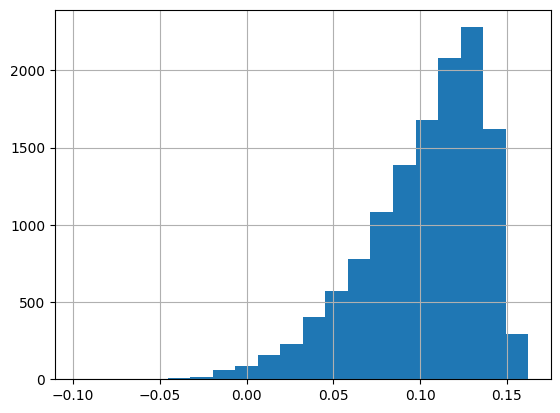

In [49]:
# histogram of anomaly scores
pd.Series(iso_forest.decision_function(embeddings)).hist(bins = 20)

In [28]:
# Filter and inspect anomalous commands
anomalies = data[data["anomaly"] == -1]
print("Anomalous Commands:")
print(anomalies)

Anomalous Commands:
                                                 command  label  anomaly
211    rsync -av --progress --exclude=*.VOB --exclude...      0       -1
223                     screen -S 'name' 'application'\n      0       -1
257                                 ifconfig eth0 down\n      0       -1
269    ls -alR -I dev -I run -I sys -I tmp -I proc /p...      0       -1
330    cat /file/with/numbers | php -r '$s = 0; while...      0       -1
...                                                  ...    ...      ...
12520                                        sleep 500\n      0       -1
38             /usr/bin/script -qc /bin/bash /dev/null\n      1       -1
58     python -c 'import socket,subprocess,os,pty;s=s...      1       -1
64     /tmp/socat exec:'bash -li',pty,stderr,setsid,s...      1       -1
75     binarylist='aria2c\|arp\|ash\|awk\|base64\|bas...      1       -1

[128 rows x 3 columns]


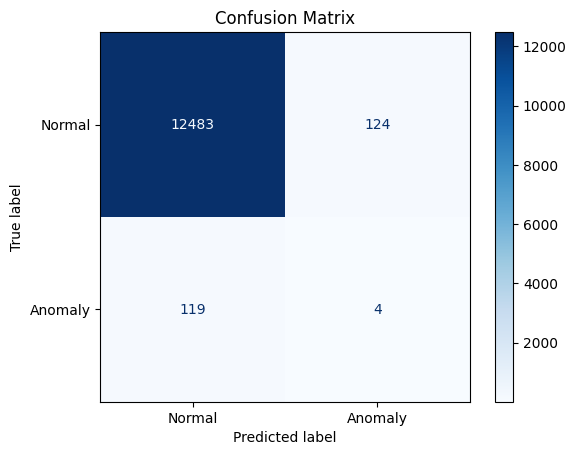

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(data.label, data.anomaly == -1)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anomaly"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [30]:
embeddings

array([[ 0.12423915,  0.09610722,  0.13251416, ...,  0.0832331 ,
        -0.37747318,  0.15544331],
       [ 0.03287267,  0.0483112 ,  0.13158159, ..., -0.19326265,
        -0.40537053,  0.4136214 ],
       [-0.05240067,  0.03378901,  0.11280235, ..., -0.3642111 ,
        -0.26696387,  0.31694528],
       ...,
       [ 0.0029096 ,  0.00958512,  0.13755839, ..., -0.3308046 ,
        -0.31713763,  0.35643888],
       [ 0.17644921,  0.14021997,  0.06951611, ...,  0.04152917,
        -0.13914667,  0.24506591],
       [ 0.11854296,  0.190349  ,  0.10325171, ..., -0.08515152,
        -0.19618762,  0.17444731]], dtype=float32)

In [ ]:
from sklearn.manifold import TSNE

# Reduce dimensions with t-SNE
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

labels = data.label
# Plot t-SNE results
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_2d[labels == 0, 0], embeddings_2d[labels == 0, 1], label="Normal", alpha=0.5, c="blue")
plt.scatter(embeddings_2d[labels == 1, 0], embeddings_2d[labels == 1, 1], label="Anomaly", alpha=0.5, c="red")
plt.title("t-SNE Plot of Unix Command Embeddings")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend()
plt.show()